# Self-Driving Car Nanodegree 

## Project: Advanced Lane Detection on curved roads

################

Write a bunch of things to explain project



################

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

#### Calibration Steps:

In [2]:
##Basic code for global use

nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

def get_image_size(img):
    return (img.shape[1], img.shape[0])

In [3]:
def get__calibration_points(cal_images):    
    '''Get imgpoints and objpoints out of list of images for camera_calibration'''
    
    objpoints = [] #object points of real world space
    imgpoints = [] #image points of the image

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    offset = 100 #Image offset for boundary spacing of pixels 

    for img_name in cal_images:
        img = mpimg.imread(img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return(imgpoints, objpoints)
    
def get_undistorted_frame(img, imgpoints, objpoints):
    
    '''Calibrate camera using the img_points, objpoints and provide the 
        undistorted image'''
    
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, get_image_size(img), None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
#Read in the camera images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

#Calibrate the camera using the calibration images
imgpoints, objpoints = get__calibration_points(cal_images)

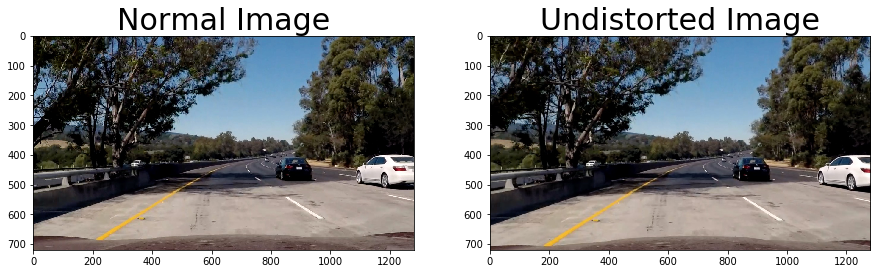

In [32]:
img = mpimg.imread('./test_images/test5.jpg')

undistorted_image = get_undistorted_frame(img, imgpoints, objpoints)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,12))

ax1.set_title('Normal Image', fontsize=30)
ax1.imshow(img)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.imshow(undistorted_image)

In [33]:
# See if the image is same or different after the undistortion
# ele, cnts = np.unique(img == undistorted_image, return_counts=True)

#### Thresholding

###### 1. Color Space Threshold

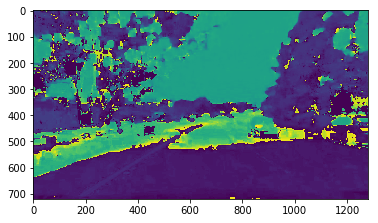

In [34]:
gray_img = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
plt.imshow(H)

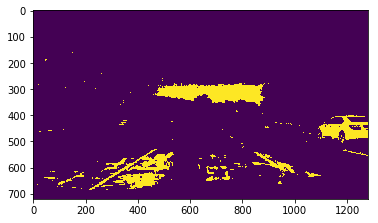

In [35]:
thresh = (180, 255)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(binary)

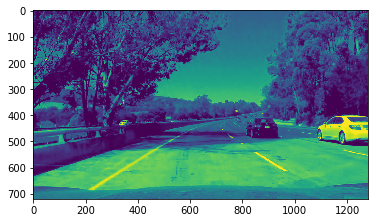

In [101]:
##R Threshold
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
thresh = (200, 255)
Rbinary = np.zeros_like(R)
Rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.imshow(R)

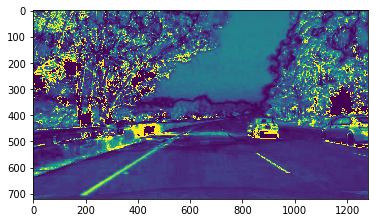

In [112]:
thresh = (150, 160)
Sbinary = np.zeros_like(S)
Sbinary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(S)

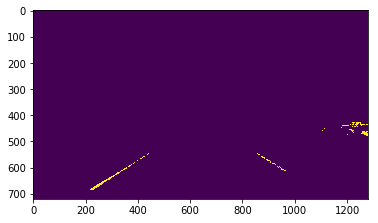

In [95]:
output = np.zeros_like(Sbinary)
output[(Sbinary == 1) & (Rbinary == 1)] = 1
plt.imshow(output)

##### 2. Gradients

In [39]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [55]:
img_size = get_image_size(img)
kernel_size = 5
low_threshold = 200
high_threshold = 250
bottom_left = [0,img_size[1]]
top_left = [450,450]
top_right = [850,450]
bottom_right = [1200,img_size[1]]
xcenter = (top_right[0] + top_left[0]) / 2
ycenter = (top_right[1] + bottom_right[1]) / 2

vertices = np.array([[bottom_left, top_left, top_right,bottom_right]], dtype=np.int32)
rho = 2
theta = np.pi/180
threshold = 20
min_line_len = 5
max_line_gap = 6

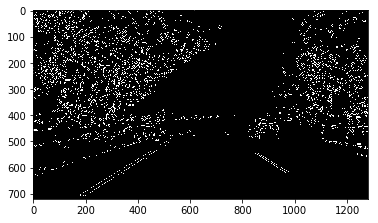

In [56]:
###CANNY IMAGE
blur_img = gaussian_blur(S, 9)
canny = cv2.Canny(blur_img, 150, 180)
plt.imshow(canny, cmap='gray')

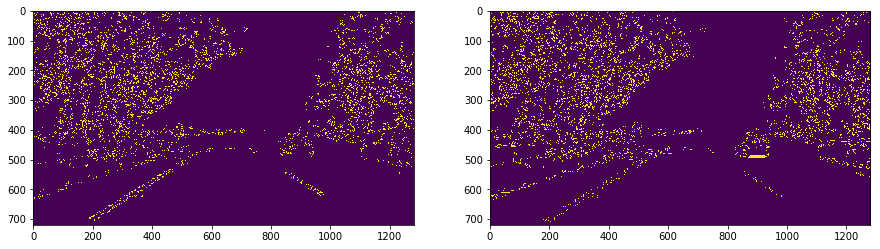

In [90]:
#Gradient Thresholded Image
mag_thresh2 = (50, 80)
dir_thresh = (0.7,1.3)
sobel_kernel = 9
sobel_thresh = (50,80)

sobelx = cv2.Sobel(canny, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
absSobelx = np.absolute(sobelx)

sobely = cv2.Sobel(canny, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
absSobely = np.absolute(sobely)


scaledSobelx = np.uint8(255*absSobelx/np.max(absSobelx))
scaledSobely = np.uint8(255*absSobely/np.max(absSobely))

SobelXBinary = np.zeros_like(scaledSobelx)
SobelYBinary = np.zeros_like(scaledSobely)
SobelXBinary[(scaledSobelx >= sobel_thresh[0]) & (scaledSobelx <= sobel_thresh[1])] = 1
SobelYBinary[(scaledSobely >= sobel_thresh[0]) & (scaledSobely <= sobel_thresh[1])] = 1

f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,12))
ax1.imshow(SobelXBinary)
ax2.imshow(SobelYBinary)

In [91]:
sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

gradmag = np.sqrt(sobelx**2 + sobely**2)
scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8) 

absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
GradBinary = np.zeros_like(gradmag)

GradBinary[(gradmag >= mag_thresh2[0]) & (gradmag <= mag_thresh2[1])#] =1  #\
              & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1


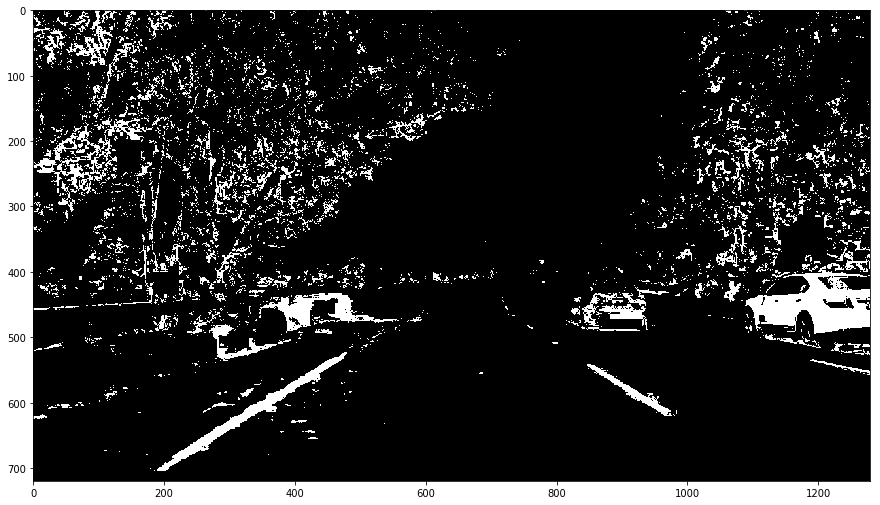

In [92]:
#A mix-match  thresholded image
mixture = np.zeros_like(SobelBinary)
mixture[ (output == 1) | (SobelYBinary == 1) & (SobelXBinary == 1) & (GradBinary == 0)] = 1
plt.figure(figsize=(15,12))
plt.imshow(mixture, cmap='gray')

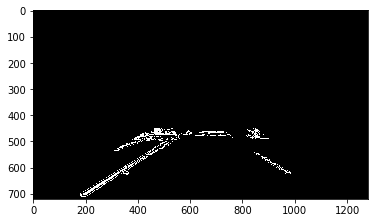

In [60]:
#Masking of the image.
masked_image = region_of_interest(mixture, vertices)
plt.imshow(masked_image, cmap='gray')

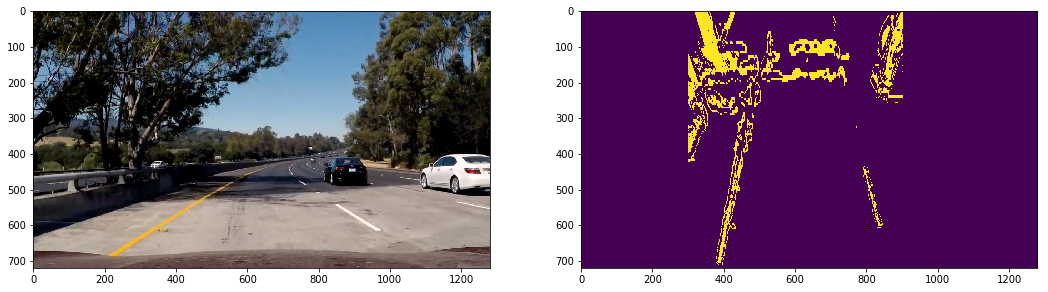

In [62]:
out_vertices =  np.float32([[300, img.shape[0]], [300,0], [900,0], [900, img.shape[0]]])
src = np.float32(vertices)
dst = out_vertices

#Get Perspective Transform needs np.float32 instead of np.array

M = cv2.getPerspectiveTransform(src, dst)
warped_img = cv2.warpPerspective(masked_image, M, get_image_size(img), flags=cv2.INTER_LINEAR)
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,15))
ax1.imshow(img)
ax2.imshow(warped_img)

In [55]:
# def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     if orient == 'x':
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     else:
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

#     absSobel = np.absolute(sobel)

#     scaledSobel = np.uint8(255*absSobel/np.max(absSobel))

#     binary_output = np.zeros_like(scaledSobel)
#     binary_output[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
#     # 6) Return this mask as your binary_output image
#     return binary_output

# sobel_img = abs_sobel_thresh(hls, orient='y', sobel_kernel=5, thresh=(50,80))
# plt.imshow(sobel_img, cmap='gray')

In [56]:
# def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
#     # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Take both Sobel x and y gradients
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     # Calculate the gradient magnitude
#     gradmag = np.sqrt(sobelx**2 + sobely**2)
#     # Rescale to 8 bit
#     scale_factor = np.max(gradmag)/255 
#     gradmag = (gradmag/scale_factor).astype(np.uint8) 
#     # Create a binary image of ones where threshold is met, zeros otherwise
#     binary_output = np.zeros_like(gradmag)
#     binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

#     # Return the binary image
#     return binary_output

# gradmag_img = mag_thresh(img, sobel_kernel=5, mag_thresh=(50, 80))
# plt.imshow(gradmag_img, cmap='gray')

In [57]:
# def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
#     # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Calculate the x and y gradients
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     # Take the absolute value of the gradient direction, 
#     # apply a threshold, and create a binary image result
#     absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     binary_output =  np.zeros_like(absgraddir)
#     binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

#     # Return the binary image
#     return binary_output

# dir_binary = dir_threshold(hls, sobel_kernel=9, thresh=(0.75, 1.0))
# plt.imshow(dir_binary, cmap='gray')

In [58]:
# ksize=9
# gradx = abs_sobel_thresh(hls, orient='x', sobel_kernel=ksize, thresh=(100,200))
# grady = abs_sobel_thresh(hls, orient='y', sobel_kernel=ksize, thresh=(150, 644))
# mag_binary = mag_thresh(hls, sobel_kernel=ksize, mag_thresh=(0, 30))
# dir_binary = dir_threshold(hls, sobel_kernel=ksize, thresh=(0,7, 1.3))#, np.pi/2))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

In [59]:
# combined_masked = region_of_interest(combined, vertices=vertices)
# plt.imshow(combined_masked, cmap='gray')

In [60]:
# f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(70,50))
# # f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=5)
# ax2.imshow(gradx, cmap='gray')
# ax2.set_title('Thresholded Sobel X.', fontsize=5)
# ax3.imshow(grady, cmap='gray')
# ax3.set_title('Thresholded Sobel Y.', fontsize=5)
# ax4.imshow(mag_binary, cmap='gray')
# ax4.set_title('Thresholded Grad. Mag', fontsize=5)
# ax5.imshow(dir_binary, cmap='gray')
# ax5.set_title('Thresholded Grad. Dir.', fontsize=5)
# ax6.imshow(combined, cmap='gray')
# ax6.set_title('Thresholded Combined.', fontsize=5)


In [61]:
# mag_thresh2 = (50, 80)
# dir_thresh = (0.7,1.3)
# sobel_kernel = 15
# sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
# sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=sobel_kernel)


# # binary_output[(sobelx >= thresh[0]) & (sobelx <= thresh[1])] = 1



# # Calculate the gradient magnitude
# gradmag = np.sqrt(sobelx**2 + sobely**2)
# # Rescale to 8 bit
# scale_factor = np.max(gradmag)/255 
# gradmag = (gradmag/scale_factor).astype(np.uint8) 

# # Calculate the direction magnitude
# absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

# # Create a binary image of ones where threshold is met, zeros otherwise
# binary_output = np.zeros_like(gradmag)
# #### binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1


# binary_output[(gradmag >= mag_thresh2[0]) & (gradmag <= mag_thresh2[1]) \
#               | (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1


# # binary_output[(sobelx >= mag_thresh2[0]) & (sobelx <= mag_thresh2[1]) \
# #              | (sobely >= mag_thresh2[0]) & (sobely <= mag_thresh2[1])] = 1


# # gradmag_img = mag_thresh(S, sobel_kernel=5, mag_thresh=(50, 80))
# plt.imshow(binary_output, cmap='gray')

In [62]:
# masked_image = region_of_interest(binary_output, vertices=vertices)
# plt.imshow(masked_image, cmap='gray')

In [ ]:
# def on_trackbar(thresh):
#     ksize=9
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh)
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 644))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 30))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     cv2.imshow(title_window, combined)

In [20]:
# from __future__ import print_function
# from __future__ import division
# import cv2 as cv
# import argparse
# alpha_slider_max = 100
# title_window = 'Linear Blend'

# # cv2.namedWindow(title_window)
# # trackbar_name = 'Threshold'
# # cv2.createTrackbar(trackbar_name, title_window , 0, 255, on_trackbar)
# # Show some stuff
# # on_trackbar(0)
# # Wait until user press some key
# # cv2.waitKey()

In [21]:
#TRY ABOVE COMMENTS LATER
#BELOW ARE WORKING CODE

In [22]:
# img = mpimg.imread("./camera_cal/calibration20.jpg")
# img_size = (img.shape[1], img.shape[0])

# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray)

In [23]:
# def get_undist_unwarp(img):

#     img_size = (img.shape[1], img.shape[0])
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#     if ret == True:
#         imgpoints.append(corners)
#         objpoints.append(objp)

#         chessImg = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

#         ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
#         undist = cv2.undistort(img, mtx, dist, None, mtx)
#         print('Undistorted Image:', len(undist[0]))
#         plt.imshow(undist)

#         offset = 100

#         src = np.float32([corners[0],
#                         corners[nx-1],
#                         corners[-1],
#                         corners[-nx]])

#         dst = np.float32([[offset,offset],
#                          [img_size[0] - offset, offset],
#                          [img_size[0] - offset, img_size[1] - offset],
#                          [offset,img_size[1] - offset]])

#         M = cv2.getPerspectiveTransform(src,dst)
#         warped = cv2.warpPerspective(undist, M, img_size)

#         return warped
#     else:
#         print('Img has squares after reduction')
#         return None

In [24]:
# def on_trackbar(thresh):
#     ksize=9
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 150))
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 644))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 30))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     plt.imshow(combined, cmap='gray')